In [2]:
%pip install tensorflow-datasets

  Using cached tensorflow_datasets-4.9.7-py3-none-any.whl (5.3 MB)
  Using cached immutabledict-4.2.1-py3-none-any.whl (4.7 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl (16 kB)
  Using cached simple_parsing-0.1.6-py3-none-any.whl (112 kB)
  Using cached tensorflow_metadata-1.16.1-py3-none-any.whl (28 kB)
  Using cached pyarrow-18.1.0-cp311-cp311-manylinux_2_28_x86_64.whl (40.1 MB)
  Using cached promise-2.3-py3-none-any.whl
  Using cached array_record-0.5.1-1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (2.2 MB)
  Using cached etils-1.11.0-py3-none-any.whl (165 kB)
  Using cached click-8.1.7-py3-none-any.whl (97 kB)
  Using cached dm_tree-0.1.8-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (152 kB)
  Using cached importlib_resources-6.4.5-py3-none-any.whl (36 kB)
  Using cached fsspec-2024.10.0-py3-none-any.whl (179 kB)
  Using cached docstring_parser-0.16-py3-none-any.whl (36 kB)
  Using cached googl

In [83]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [125]:
from tensorflow.python.framework.convert_to_constants import  convert_variables_to_constants_v2_as_graph

def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(
        [tf.TensorSpec([1, *inputs.shape[1:]]) for inputs in model.inputs])
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        return flops.total_float_ops

def analyze(model):
    print('='*21, ' Model Info', '='*21)
    trainableParams = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    nonTrainableParams = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])
    totalParams = trainableParams + nonTrainableParams
    
    print('Trainable params:',trainableParams)
    print('Nontrainable params:',nonTrainableParams)
    print('Total params:', totalParams)
    print('Flops:', get_flops(model))
    print('='*21, 'End of Info', '='*21)

In [41]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds, val_ds, ds_info = tfds.load(
    'cifar100',
    split=['train', 'test'],
    as_supervised=True,  # returns `(img, label)` instead of dict(image=, ...)
    with_info=True,
)
ds = ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds = ds.cache().shuffle(ds_info.splits['train'].num_examples).batch(128).prefetch(tf.data.experimental.AUTOTUNE)

# val_ds = tfds.load(
#     'cifar100',
#     split='test',
#     as_supervised=True,  # returns `(img, label)` instead of dict(image=, ...)
#     with_info=False,
# )
val_ds = val_ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(128).prefetch(tf.data.experimental.AUTOTUNE)

In [7]:
ds_info.features

FeaturesDict({
    'coarse_label': ClassLabel(shape=(), dtype=int64, num_classes=20),
    'id': Text(shape=(), dtype=string),
    'image': Image(shape=(32, 32, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=100),
})

(128, 32, 32, 3) (128,)
tf.Tensor(
[0.99999994 1.         1.         1.         0.99999994 1.0000001
 0.99999994 0.99999994 0.99999994 0.99999994 0.99999994 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.99999994 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.99999994 0.9999999  1.         1.
 1.         0.99999994 1.         1.         1.         0.99999994
 1.         1.         1.         1.         0.99999994 0.99999994
 1.         1.         1.         1.         1.         0.99999994
 1.         0.99999994 1.0000001  0.99999994 1.         1.
 0.9999999  1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.9999999  1.         0.99999994 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.9999999  1.
 1.         0.99999994 1.         1.         0.99

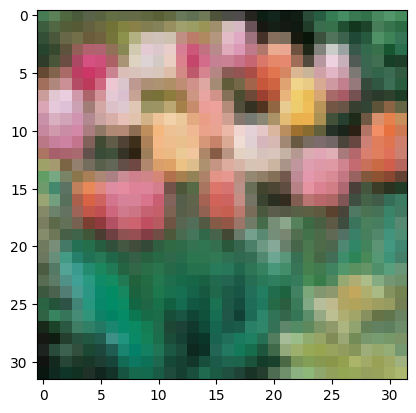

In [56]:
img = ds.take(1)
for i in img:
    print(i[0].shape, i[1].shape)
    plt.imshow(tf.cast(i[0][0]*255, tf.uint8))
    print(tf.reduce_sum(model(i[:1]), axis=1))
# model(img)

In [128]:
histories=[]
models = [
    (keras.applications.ResNet50V2, 'ResNet50V2'),
    # (keras.applications.InceptionV3, 'InceptionV3'),
    (keras.applications.DenseNet121, 'DenseNet121'),
    (keras.applications.EfficientNetV2B0, 'efficientnetv2-b0'),
]
for m, n in models:
    model = m(
        include_top=True,
        weights=None,
        # input_tensor=None,
        input_shape=ds_info.features['image'].shape,
        pooling=None,
        classes=ds_info.features['label'].num_classes,
        classifier_activation="softmax",
        name=n,
    )
    # model.summary()
    analyze(model)
    # model.compile(
    #     optimizer=keras.optimizers.AdamW(),
    #     loss=keras.losses.SparseCategoricalCrossentropy(),
    #     metrics=[keras.metrics.SparseCategoricalAccuracy()],
    # )
    # history = model.fit(ds, epochs=30, validation_data=val_ds)
    # histories.append(history)

=====================  Model Info =====================
Trainable params: 23724260
Nontrainable params: 45440
Total params: 23769700


I0000 00:00:1734544820.682878    1386 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734544820.683021    1386 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-12-18 18:00:20.683078: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
I0000 00:00:1734544820.683271    1386 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734544820.683388    1386 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

I0000 00:00:1734544824.291501    1386 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734544824.291643    1386 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-12-18 18:00:24.291708: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
I0000 00:00:1734544824.292048    1386 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734544824.292148    1386 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

I0000 00:00:1734544829.563171    1386 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734544829.563324    1386 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-12-18 18:00:29.563407: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
I0000 00:00:1734544829.563585    1386 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734544829.563685    1386 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

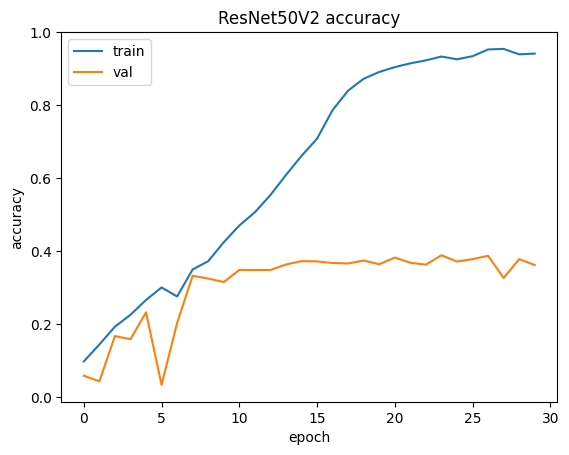

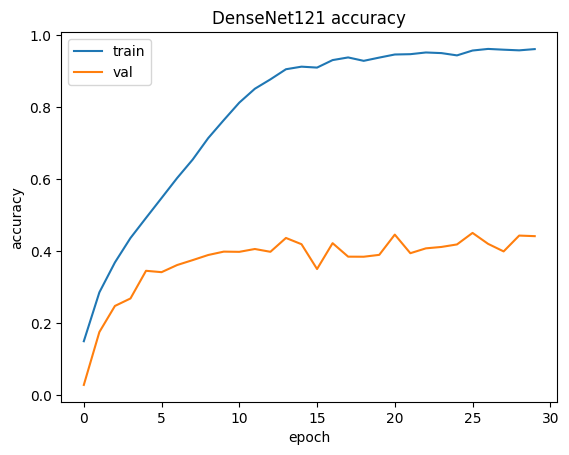

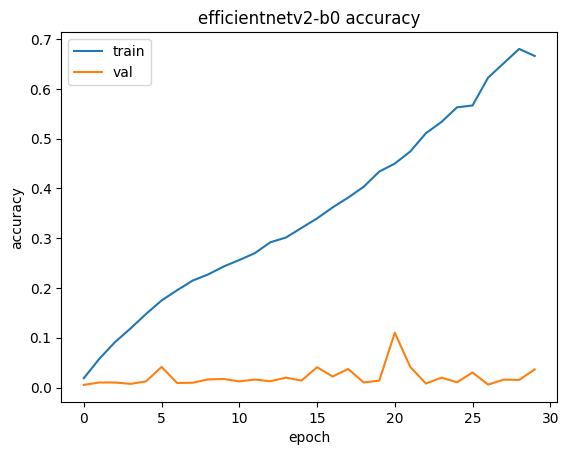

In [110]:
for h, (m,n) in zip(histories[1:], models):
    plt.plot(h.history['sparse_categorical_accuracy'])
    plt.plot(h.history['val_sparse_categorical_accuracy'])
    plt.title(f'{n} accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [77]:
q = tf.convert_to_tensor(np.arange(5).reshape(1,5), tf.float32)
k = tf.convert_to_tensor(np.arange(5,10).reshape(1,5), tf.float32)
v = tf.convert_to_tensor(np.arange(10,15).reshape(1,5), tf.float32)

In [78]:
q

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=array([[0., 1., 2., 3., 4.]], dtype=float32)>

In [79]:
tf.transpose(k)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[5.],
       [6.],
       [7.],
       [8.],
       [9.]], dtype=float32)>

In [81]:
tf.transpose(k)@q

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[ 0.,  5., 10., 15., 20.],
       [ 0.,  6., 12., 18., 24.],
       [ 0.,  7., 14., 21., 28.],
       [ 0.,  8., 16., 24., 32.],
       [ 0.,  9., 18., 27., 36.]], dtype=float32)>

In [88]:
@tf.keras.utils.register_keras_serializable()
class Conv_Block(tf.keras.layers.Layer):
    def __init__(self, kernel, filters, stride, activation=tf.nn.relu6, **kwargs):
        super(Conv_Block, self).__init__(**kwargs)
        self.kernel = kernel
        self.filters = filters
        self.activation = activation
        self.stride = stride

    def get_config(self):
        config = super().get_config()
        config.update({
            'kernel': self.kernel,
            'filters': self.filters,
            'stride': self.stride,
            'activation': self.activation
        })
        return config

    def build(self, input_shape):
        self.bn1 = layers.BatchNormalization()
        self.conv = layers.SeparableConv2D(self.filters,self.kernel,self.stride,'same',activation=self.activation)
    
    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn1(x)
        return x


@tf.keras.utils.register_keras_serializable()
class VOV_Block(tf.keras.layers.Layer):
    def __init__(self, filters_out, n_layers, layer_filter=None, activation='relu6', ese=None, identity=False, use_mobile=False, **kwargs):
        super(VOV_Block, self).__init__(**kwargs)
        self.filters_out = filters_out
        self.n_layers = n_layers
        self.layer_filter = layer_filter
        self.activation = activation
        self.identity = identity
        self.use_mobile = use_mobile
        self.ese = ese
        
    def get_config(self):
        config = super().get_config()
        config.update({
            'filters_out': self.filters_out,
            'layer_filter': self.layer_filter,
            'n_layers': self.n_layers,
            'activation': self.activation,
            'ese': self.ese,
            'identity': self.identity,
            'use_mobile': self.use_mobile,
        })
        return config

    # input shape requires channel last
    def build(self, input_shape): 
        n  = self.layer_filter if self.layer_filter is not None else input_shape[-1]
        if (self.use_mobile):
            self.convs = [Conv_Block(3, n, 1, activation=self.activation) for _ in range(self.n_layers)]
        else:
            self.convs = [layers.Conv2D(n, 3, padding='same', activation=self.activation) for _ in range(self.n_layers)]
        self.conv_out = layers.Conv2D(self.filters_out, 1, padding='same', activation=self.activation)
        if (self.identity):
            self.add = layers.Add()

    def call(self, inputs):
        x = inputs
        layers = [x]
        for c in self.convs:
            x = c(x)
            layers += [x]
        x = tf.concat(layers, -1)
        out = self.conv_out(x)
        if (self.ese):
            out = self.ese(out)
        if (self.identity):
            out = self.add([inputs, out])
        return out


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_222 (Conv2D)             │ (None, 15, 15, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_223 (Conv2D)             │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_224 (Conv2D)             │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vov__block_37 (VOV_Block)       │ (None, 11, 11, 128)    │       278,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vov__block_38 (VOV_Block)       │ (None, 5, 5, 256)      │       458,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vov__block_39 (VOV_Block)       │ (None, 2, 2, 384)      │       836,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (None, 1, 1, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vov__block_40 (VOV_Block)       │ (None, 1, 1, 512)      │     1,323,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_out (Softmax)           │ (None, 100)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,060,740 (11.68 MB)

 Trainable params: 3,060,740 (11.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


2024-12-18 17:51:51.973489: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3222', 180 bytes spill stores, 180 bytes spill loads



391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 4.3960 - sparse_categorical_accuracy: 0.0278 - val_loss: 3.8023 - val_sparse_categorical_accuracy: 0.1067
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 3.6866 - sparse_categorical_accuracy: 0.1242 - val_loss: 3.3960 - val_sparse_categorical_accuracy: 0.1845
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 3.2767 - sparse_categorical_accuracy: 0.1984 - val_loss: 3.1558 - val_sparse_categorical_accuracy: 0.2242
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 2.9834 - sparse_categorical_accuracy: 0.2560 - val_loss: 2.8903 - val_sparse_categorical_accuracy: 0.2791
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 2.7220 - sparse_categorical_accuracy: 0.3035 - val_loss: 2.7723 - val_sparse_categorical_accuracy: 0.3040
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 2.5170 - sparse_categorical_accuracy: 0.3418 - val_loss: 2.6260 - val_sparse_categorical_accuracy: 0.3341
Epoch 7/

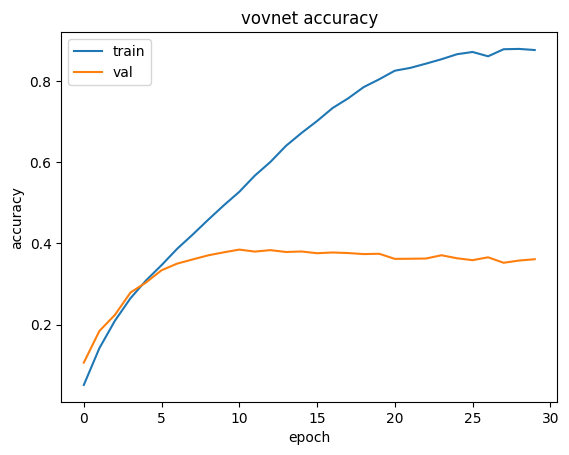

In [114]:
activation = 'relu6'
inp = tf.keras.Input(ds_info.features['image'].shape,name='input')
### stage 1
x = layers.Conv2D(64, 3, strides=2, padding='valid', activation=activation)(inp)
x = layers.Conv2D(64, 3, strides=1, padding='valid', activation=activation)(x)
x = layers.Conv2D(128, 3, strides=1, padding='valid', activation=activation)(x)
### stage 2
x = VOV_Block(128, 5, 64, identity=True)(x)
x = layers.MaxPool2D(3, 2)(x)
### stage 3
x = VOV_Block(256, 5, 80)(x)
x = layers.MaxPool2D(3, 2)(x)
### stage 4
x = VOV_Block(384, 5, 96)(x)
x = layers.MaxPool2D(2, 1)(x)
### stage 5
x = VOV_Block(512, 5, 112)(x)
### out
out = layers.GlobalAveragePooling2D('channels_last')(x)
out = layers.Dense(ds_info.features['label'].num_classes)(out)
out = layers.Softmax(name='softmax_out')(out)

model = tf.keras.Model(inputs=[inp], outputs=[out])
model.summary()

model.compile(
    optimizer=keras.optimizers.AdamW(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
history = model.fit(ds, epochs=30, validation_data=val_ds)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('vovnet accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [126]:
analyze(model)

=====================  Model Info =====================
Trainable params: 3060740
Nontrainable params: 0.0
Total params: 3060740.0


I0000 00:00:1734544700.556328    1386 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734544700.556572    1386 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-12-18 17:58:20.556627: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
I0000 00:00:1734544700.556801    1386 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734544700.556928    1386 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Flops: 130973016
===================== End of Info =====================

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops

In [131]:
import gc
del model 
tf.keras.backend.clear_session()
gc.collect()

0